Số quan sát: 24
Train samples: 16
Test samples : 5


C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Huấn luyện RNN hoàn tất
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

===== ĐÁNH GIÁ MÔ HÌNH RNN =====
MAE = 10,646,738,470 USD | RMSE = 12,827,731,093 USD | R² = 0.8887


,Year,GDP_Thực_tế,GDP_Dự_đoán
0,2019,3.343650e+11,3.377001e+11
1,2020,3.466160e+11,3.618805e+11
2,2021,3.664750e+11,3.719711e+11
3,2022,4.134450e+11,3.910049e+11
4,2023,4.338580e+11,4.405559e+11


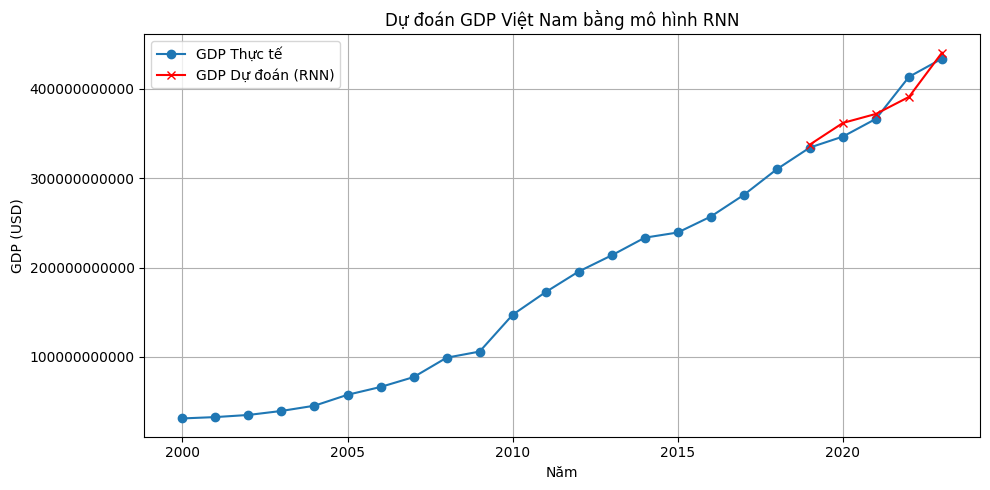

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

# 1. ĐỌC DỮ LIỆU
df = pd.read_csv("macro_vietnam_processed.csv")

# Lấy chuỗi GDP theo năm
gdp = df["GDP"].values.reshape(-1, 1)
years = df["Year"].values

print("Số quan sát:", len(gdp))

# 2. CHUẨN HÓA DỮ LIỆU
scaler = MinMaxScaler()
gdp_scaled = scaler.fit_transform(gdp)

# 3. TẠO DỮ LIỆU DẠNG CHUỖI (SLIDING WINDOW)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 3  # dùng 3 năm trước để dự đoán năm tiếp theo

X, y = create_sequences(gdp_scaled, window_size)

# 4. CHIA TRAIN / TEST (GIẤU 5 NĂM CUỐI)
n_test = 5

X_train = X[:-n_test]
X_test  = X[-n_test:]

y_train = y[:-n_test]
y_test  = y[-n_test:]

years_test = years[window_size + len(X_train):]

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])

# 5. XÂY DỰNG MÔ HÌNH RNN
model = Sequential([
    SimpleRNN(32, activation="tanh", input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss="mse"
)

# 6. HUẤN LUYỆN MÔ HÌNH
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=4,
    verbose=0
)

print("Huấn luyện RNN hoàn tất")

# 7. DỰ ĐOÁN & ĐÁNH GIÁ
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_real = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)

print("\n===== ĐÁNH GIÁ MÔ HÌNH RNN =====")
print(
    f"MAE = {mae:,.0f} USD | "
    f"RMSE = {rmse:,.0f} USD | "
    f"R² = {r2:.4f}"
)

# 8. BẢNG SO SÁNH THỰC TẾ & DỰ ĐOÁN
result_df = pd.DataFrame({
    "Year": years_test,
    "GDP_Thực_tế": y_test_real.flatten(),
    "GDP_Dự_đoán": y_pred.flatten()
})

display(result_df)

# 9. BIỂU ĐỒ SO SÁNH
plt.figure(figsize=(10,5))

plt.plot(years, gdp, label="GDP Thực tế", marker="o")
plt.plot(years_test, y_pred, label="GDP Dự đoán (RNN)", marker="x", color="red")

plt.title("Dự đoán GDP Việt Nam bằng mô hình RNN")
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.legend()
plt.grid(True)
plt.ticklabel_format(style="plain", axis="y")

plt.tight_layout()
plt.show()
